## first lets visualize some of our images 

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

images = []
path = "C:/Users/mplan/Desktop/my_stuff/projects/leaf_desease/data"
for file in os.listdir(path):
    path2 = path + '/' + file
    k = 1
    
    for image in os.listdir(path2):
        if k < 6:
            image_ = path2 + '/' + image
            images.append(image_)
            k += 1 
        else:
            break
    
        
        
 ## get only 5 of each class    

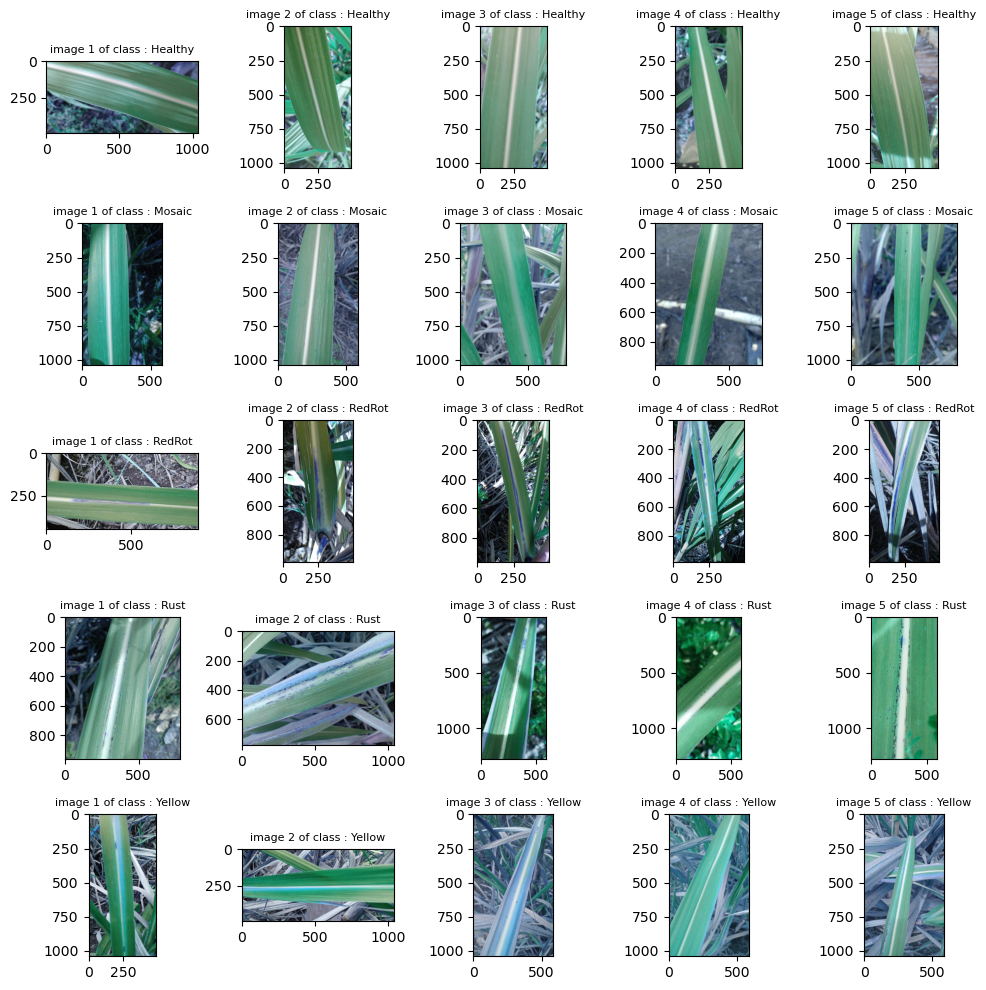

In [2]:
clases = [ file for file in  os.listdir(path)]
## visualization
import cv2

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt
    read_ = cv2.imread(images[i])
    plt.imshow(read_)
    if i <=4 : 
        plt.title(f'image {i+1} of class : {clases[0]}',fontsize=8)
    elif i >=4 and i <= 9:
        plt.title(f'image {i-5+1} of class : {clases[1]}',fontsize=8)
    elif i>= 9 and i<= 14:
        plt.title(f'image {i-10+1} of class : {clases[2]}',fontsize=8)
    elif i >=14 and i<=19:
        plt.title(f'image {i-15+1} of class : {clases[3]}',fontsize=8)
    else:
        plt.title(f'image {i-20+1} of class : {clases[4]}',fontsize=8)
plt.tight_layout()
plt.show()
    

## import images in tensorflow dataset

In [3]:
images = tf.data.Dataset.list_files('data/*/*',shuffle=True)

In [4]:
for image in images.take(10):
    print(image.numpy())

b'data\\Healthy\\healthy (1).jpeg'
b'data\\Mosaic\\mosaic (415).jpeg'
b'data\\Rust\\rust (169).jpeg'
b'data\\Rust\\rust (45).jpeg'
b'data\\Mosaic\\mosaic (462).jpeg'
b'data\\Rust\\rust (455).jpeg'
b'data\\Healthy\\healthy (6).jpeg'
b'data\\Healthy\\healthy (180).jpeg'
b'data\\Rust\\rust (225).jpeg'
b'data\\Rust\\rust (88).jpeg'


In [5]:
class_names = ['Healthy','Mosaic','RedRot','Rust','Yellow']

## create train_test_val_split


In [6]:

images_count = len(images)
images_count
train_size = int(images_count *0.8)

train_ds = images.take(train_size)
test_ds = images.skip(train_size).take(int(images_count *0.1))
val_ds = images.skip(int(images_count *0.9)).take(int(images_count *0.1))


len(train_ds),len(test_ds),len(val_ds)

(2008, 251, 251)

In [7]:
['Healthy','Mosaic','RedRot','Rust','Yellow']

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

## create the labels

In [8]:
def get_label(path):
    x = tf.strings.split(path,'\\')[-2]
    if x == 'Healthy':
        return 0 
    elif x == 'Mosaic':
        return 1
    elif x == 'RedRot':
        return 2
    elif x == 'Rust':
        return 3
    else :
        return 4 
    


for label in train_ds.map(get_label):
    print(label)
    break

tf.Tensor(2, shape=(), dtype=int32)


## create images 

In [9]:
def get_image(path):
    label = get_label(path)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,[256,256])
    img = img/255
    return img,label



for img,label in train_ds.map(get_image):
    print(label,img[0][0])
    break

tf.Tensor(2, shape=(), dtype=int32) tf.Tensor([0.7136044  0.7528201  0.65870243], shape=(3,), dtype=float32)


In [10]:
train_ds = train_ds.map(get_image)
test_ds = test_ds.map(get_image)
val_ds = val_ds.map(get_image)

In [11]:
for image,label in train_ds.take(1):
    print(f'image = {image[0][0]}')
    print(f'label = {label}')

image = [0.04705882 0.01568628 0.00784314]
label = 3


## make y categorical 

In [12]:
def label_to_categorical(image, label):
    label = tf.one_hot(label, 5)
    label = tf.cast(label, tf.float32)
    
    return image, label

train_ds = train_ds.map(label_to_categorical)
test_ds = test_ds.map(label_to_categorical)
val_ds = val_ds.map(label_to_categorical)

In [13]:
for k,i in train_ds.take(10).as_numpy_iterator():
    print(i)

[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]


## prefetch and cache for faster training

In [14]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache().batch(20)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE).cache().batch(20)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).cache().batch(20)

In [15]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## create the model 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [17]:
model = Sequential()
model.add(Input(shape=(256,256,3)))

model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(200))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation("softmax"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                         

Total params: 59309677 (226.25 MB)
Trainable params: 59303557 (226.23 MB)
Non-trainable params: 6120 (23.91 KB)
_________________________________________________________________


## compile

In [19]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## callbacks

In [20]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau,ModelCheckpoint



checkpoint = ModelCheckpoint(
    'weights.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch")

stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="auto",
    baseline=None,
    start_from_epoch=10,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3
)

## training 

In [21]:
history = model.fit(train_ds,validation_data = val_ds,epochs=100,callbacks=[stop,reduce_lr,checkpoint])

Epoch 1/100



101/101 [==============================] - 325s 3s/step - loss: 1.9295 - accuracy: 0.3740 - val_loss: 20.5338 - val_accuracy: 0.1434 - lr: 0.0010
Epoch 2/100
101/101 [==============================] - 301s 3s/step - loss: 1.3627 - accuracy: 0.5149 - val_loss: 14.7280 - val_accuracy: 0.1434 - lr: 0.0010
Epoch 3/100
101/101 [==============================] - 301s 3s/step - loss: 1.1595 - accuracy: 0.5966 - val_loss: 6.8856 - val_accuracy: 0.2191 - lr: 0.0010
Epoch 4/100
101/101 [==============================] - 301s 3s/step - loss: 1.0011 - accuracy: 0.6579 - val_loss: 10.3436 - val_accuracy: 0.1434 - lr: 0.0010
Epoch 5/100
101/101 [==============================] - 302s 3s/step - loss: 0.9020 - accuracy: 0.6713 - val_loss: 5.3857 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 6/100
101/101 [==============================] - 301s 3s/step - loss: 0.8282 - accuracy: 0.7112 - val_loss: 0.8835 - val_accuracy: 0.6574 - lr: 0.0010
Epoch 7/100
101/101 [==============================] - 300s 3s/step

## lets see how was training

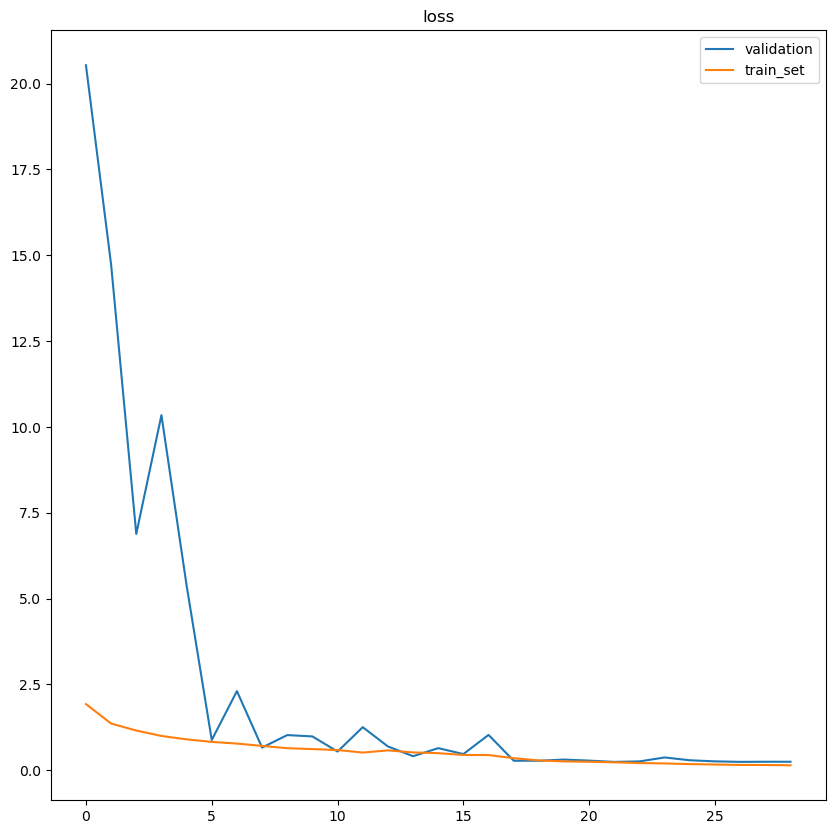

In [22]:

plt.figure(figsize=(10,10))
plt.plot(history.history['val_loss'],label='validation')
plt.plot(history.history['loss'],label='train_set')
plt.title('loss')
plt.legend()
plt.show()

In [23]:
# accuracy

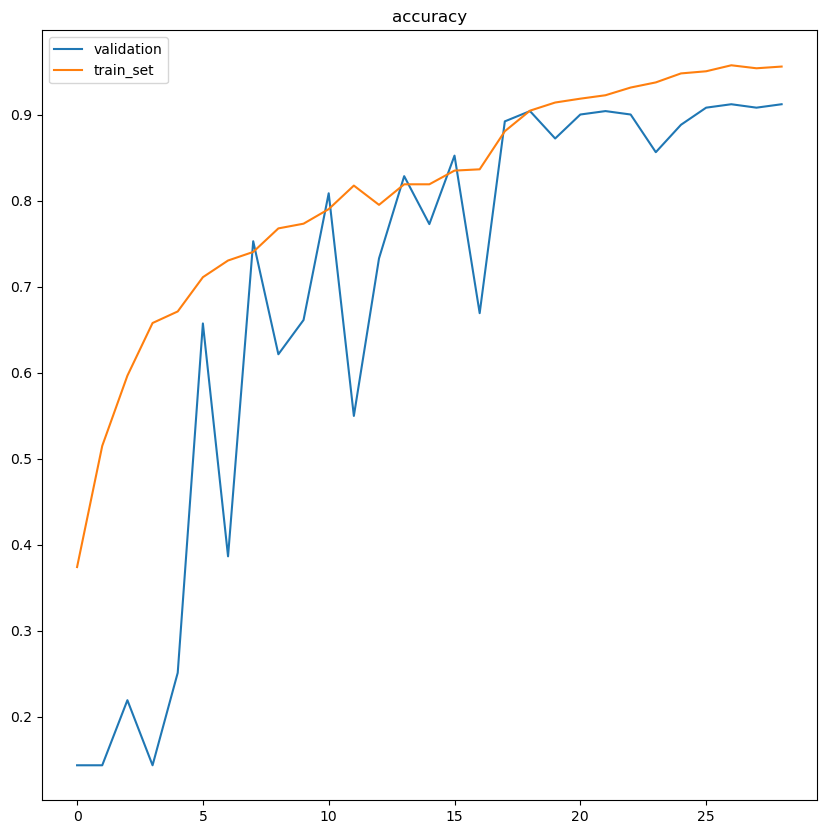

In [24]:
plt.figure(figsize=(10,10))
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history['accuracy'],label='train_set')
plt.title('accuracy')
plt.legend()
plt.show()

## load best weights

In [25]:
model.load_weights('weights.h5')

## predictions 

In [26]:
preds = model.predict(test_ds)

13/13 [==============================] - 11s 722ms/step


In [27]:

# get predictions 
predicted = []

for i in range(len(preds)):
    predicte = np.argmax(preds[i])
    predicted.append(predicte)
    
# get  true labels
y_test = np.concatenate([y for x, y in test_ds], axis=0) 
y_test_ = []
for i in range(len(y_test)):
    test = np.argmax(y_test[i])
    y_test_.append(test)

## metrics 

In [28]:
from sklearn.metrics import confusion_matrix as cm , accuracy_score as acc

ac_score = acc(y_test_,predicted)
print(ac_score)

0.9123505976095617


<Axes: >

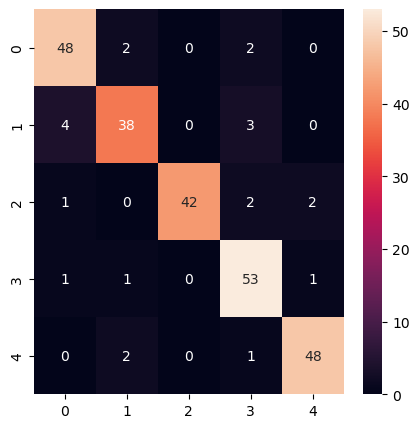

In [29]:
plt.figure(figsize=(5,5))
conf_matrix = cm(y_test_,predicted)
sns.heatmap(conf_matrix,annot=True,fmt='.0f')

## our model does a very good job with accuracy score equal to 0.91